## Data exploration ##

J'ai essayé de commencer avec un truc assez simple. Première approche sans NLP, je veux juste regarder naivement le lien entre les discours et le marché. Je regarde pas le texte, juste la date du discours, le speaker et le word_count. On essaie de voir si on identifie des patterns comme ça. Pour les discours qui ne génèrent pas de réactions des marchés, deux possibilités : soit discours "inutile" soit saturation avec ce discours. On verra ça quand on classera les discours suivant leur thème.

En vrai la méthode est criticable en particulier parce que certains discours sont faits le même jour mais bon c'est une première approche.

Pour la market data j'ai pris pour l'instant le S&P 500, le US 10Y treasury yield et le US Dollar Index. On regarde la réaction du marché sur un horizon de 1 à 3 jours. J'ai pris la variation du prix de clôture de l'indice, là pareil on pourra prendre des métriques plus intéressantes faudra voir (la vol impli peut être pas mal par exemple). 

En termes de résultats il semble que le nombre de mots n'est pas trop corrélé avec une réaction du marché, par contre le speaker si ( en vrai difficile à dire, on a pas bcp de données par speaker). 

Prochaines étapes (idées) : 

- Retravailler tout ça, en particulier prendre des métriques de réaction de marché comme VIX, log returns ...
- Prédire la réaction du marché à un speech, à partir de NLP (champ lexical, ton employé ...) et des variables speaker, word_count  
- Tester si certains mots corrèlent avec une réaction négative ou positive

- Ensuite pour étudier la saturation on peut faire un truc fréquence de speechs vs réaction du marché, mais ici on est pas sûr que les speechs parlent de la même chose à chaque fois
- Ducoup on affine en regroupant les textes similaires entre eux, et voir l'impact d'une répétition de discours

A voir si on a assez de données pour ça, sinon on pourra prendre de la data d'autres banques centrales.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_speeches = pd.read_csv("fed_speeches_full.csv")
df_speeches["date"] = pd.to_datetime(df_speeches["date"])
df_speeches = df_speeches.sort_values("date")
df_speeches.head()

,date,title,speaker,url,word_count,text
640,2017-01-07,Low Interest Rates and the Financial System,Governor Jerome H. Powell,https://www.federalreserve.gov/newsevents/spee...,2127,Thank you for this invitation to discuss low i...
639,2017-01-12,Welcoming Remarks,Chair Janet L. Yellen,https://www.federalreserve.gov/newsevents/spee...,1038,"Thank you, and thank you to all the educators ..."
638,2017-01-17,Monetary Policy in a Time of Uncertainty,Governor Lael Brainard,https://www.federalreserve.gov/newsevents/spee...,3185,There are many sources of uncertainty affectin...
637,2017-01-18,The Goals of Monetary Policy and How We Pursue...,Chair Janet L. Yellen,https://www.federalreserve.gov/newsevents/spee...,2973,Good afternoon. It is a pleasure to join all o...
636,2017-01-19,The Economic Outlook and the Conduct of Moneta...,Chair Janet L. Yellen,https://www.federalreserve.gov/newsevents/spee...,4609,It is a privilege to be here today to discuss ...


In [3]:
import yfinance as yf

sp = yf.download("^GSPC", start="2015-01-01", end="2025-10-15", group_by="Ticker")
tnx = yf.download("^TNX", start="2015-01-01", end="2025-10-15", group_by="Ticker")
dxy = yf.download("DX-Y.NYB", start="2015-01-01", end="2025-10-15", group_by="Ticker")

C:\Users\alexn\AppData\Local\Temp\ipykernel_31240\2897215718.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp = yf.download("^GSPC", start="2015-01-01", end="2025-10-15", group_by="Ticker")
[*********************100%***********************]  1 of 1 completed
C:\Users\alexn\AppData\Local\Temp\ipykernel_31240\2897215718.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tnx = yf.download("^TNX", start="2015-01-01", end="2025-10-15", group_by="Ticker")
[*********************100%***********************]  1 of 1 completed
C:\Users\alexn\AppData\Local\Temp\ipykernel_31240\2897215718.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dxy = yf.download("DX-Y.NYB", start="2015-01-01", end="2025-10-15", group_by="Ticker")
[*********************100%***********************]  1 of 1 completed


On regarde pour chaque indice sa variation à la clôture 1 jour après et 3 jours après

In [4]:
for df, prefix in zip([sp, tnx, dxy], ["sp", "tnx", "dxy"]):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(1)
    df.reset_index(inplace=True) 
    df.rename(columns={"Date": "date", "Close": f"{prefix}_close"}, inplace=True)
    df["date"] = pd.to_datetime(df["date"])
    df[f"{prefix}_delta_1d"] = df[f"{prefix}_close"].diff().shift(-1)
    df[f"{prefix}_delta_3d"] = df[f"{prefix}_close"].diff(periods=3).shift(-3)

In [5]:
# Merge les discours avec les marchés
df_merged = df_speeches.merge(sp, on="date", how="left")
df_merged = df_merged.merge(tnx, on="date", how="left")
df_merged = df_merged.merge(dxy, on="date", how="left")

df_merged.to_csv("fed_speeches_with_market.csv", index=False)

In [6]:
df_merged.columns

Index(['date', 'title', 'speaker', 'url', 'word_count', 'text', 'Open_x',
       'High_x', 'Low_x', 'sp_close', 'Volume_x', 'sp_delta_1d', 'sp_delta_3d',
       'Open_y', 'High_y', 'Low_y', 'tnx_close', 'Volume_y', 'tnx_delta_1d',
       'tnx_delta_3d', 'Open', 'High', 'Low', 'dxy_close', 'Volume',
       'dxy_delta_1d', 'dxy_delta_3d'],
      dtype='object')

In [7]:
cols_to_keep = [
    "date", "title", "speaker", "word_count",
    "sp_close", "sp_delta_1d", "sp_delta_3d",
    "tnx_close", "tnx_delta_1d", "tnx_delta_3d",
    "dxy_close", "dxy_delta_1d", "dxy_delta_3d"
]

df_merged = df_merged[cols_to_keep]

df_merged = df_merged.dropna(subset=[
    "sp_delta_1d", "sp_delta_3d",
    "tnx_delta_1d", "tnx_delta_3d",
    "dxy_delta_1d", "dxy_delta_3d"
])

df_merged.head()

,date,title,speaker,word_count,sp_close,sp_delta_1d,sp_delta_3d,tnx_close,tnx_delta_1d,tnx_delta_3d,dxy_close,dxy_delta_1d,dxy_delta_3d
1,2017-01-12,Welcoming Remarks,Chair Janet L. Yellen,1038,2270.439941,4.199951,1.449951,2.361,0.019,0.028,101.349998,-0.169998,-0.419998
2,2017-01-17,Monetary Policy in a Time of Uncertainty,Governor Lael Brainard,3185,2267.889893,4.000000,3.420166,2.327,0.062,0.140,100.330002,0.599998,0.409996
3,2017-01-18,The Goals of Monetary Policy and How We Pursue...,Chair Janet L. Yellen,2973,2271.889893,-8.199951,-6.689941,2.389,0.070,0.014,100.930000,0.220001,-0.769997
4,2017-01-19,The Economic Outlook and the Conduct of Moneta...,Chair Janet L. Yellen,4609,2263.689941,7.620117,16.380127,2.459,0.008,0.012,101.150002,-0.410004,-0.800003
6,2017-02-22,The Economic Outlook and Monetary Policy,Governor Jerome H. Powell,3349,2362.820068,0.989990,6.929932,2.418,-0.030,-0.049,101.330002,-0.279999,-0.200005


--- sp_delta_1d ---
Moyenne : -1.419148229380123
Écart-type : 49.52391088021207
Proportion positive : 0.5360655737704918
Proportion négative : 0.4639344262295082
Proportion neutre : 0.0

--- sp_delta_3d ---
Moyenne : 4.904716716828894
Écart-type : 80.65848741947816
Proportion positive : 0.5819672131147541
Proportion négative : 0.4180327868852459
Proportion neutre : 0.0

--- tnx_delta_1d ---
Moyenne : 0.0004491838275409136
Écart-type : 0.055943776703372576
Proportion positive : 0.5081967213114754
Proportion négative : 0.47704918032786886
Proportion neutre : 0.01639344262295082

--- tnx_delta_3d ---
Moyenne : 0.003606553839855507
Écart-type : 0.09130142328198386
Proportion positive : 0.5147540983606558
Proportion négative : 0.47540983606557374
Proportion neutre : 0.01639344262295082

--- dxy_delta_1d ---
Moyenne : 0.005869030561603483
Écart-type : 0.38598052304151104
Proportion positive : 0.4819672131147541
Proportion négative : 0.5081967213114754
Proportion neutre : 0.009836065573770493

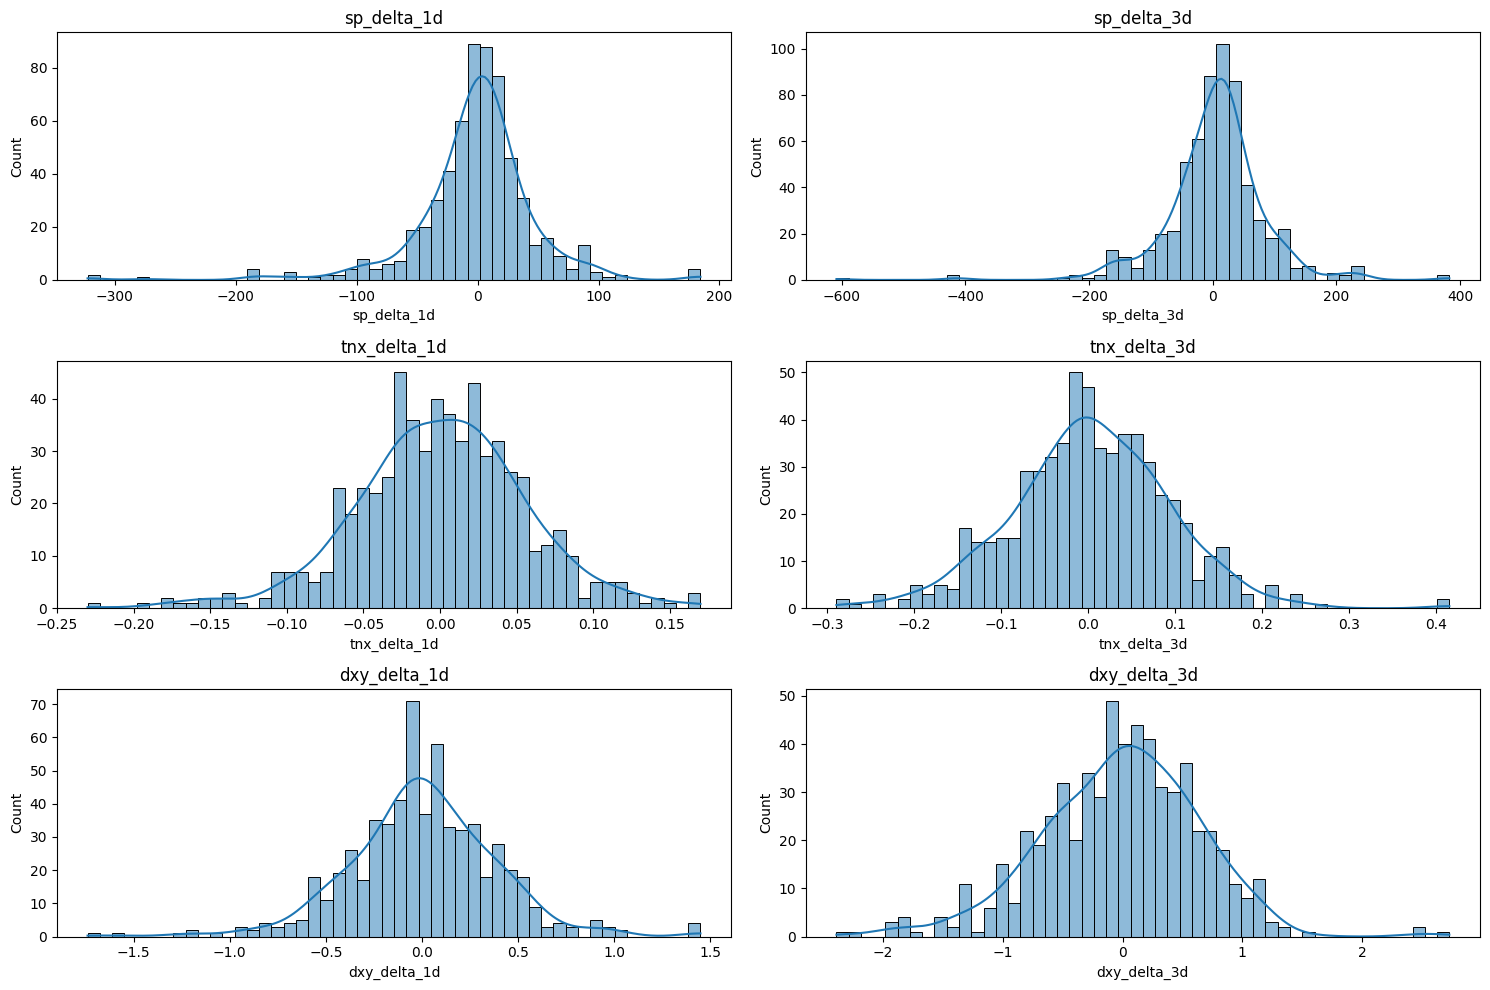

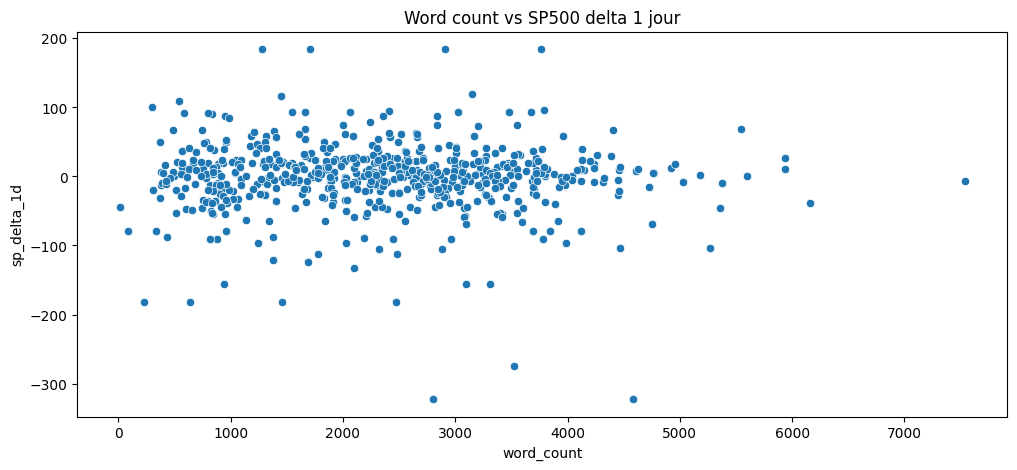

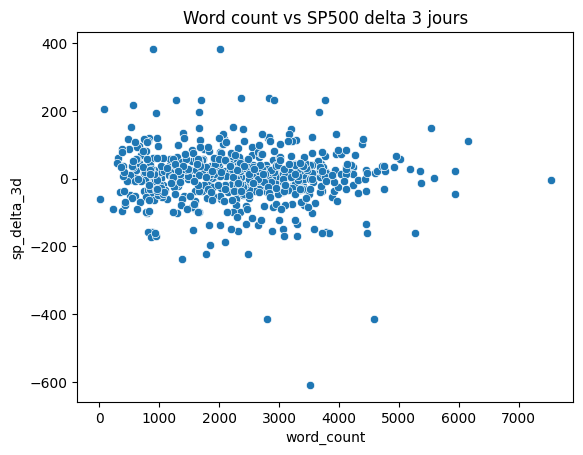

In [ ]:
# Colonnes deltas à analyser
deltas = ["sp_delta_1d", "sp_delta_3d", "tnx_delta_1d", "tnx_delta_3d", "dxy_delta_1d", "dxy_delta_3d"]

# Stats simples
for col in deltas:
    print(f"--- {col} ---")
    print("Moyenne :", df_merged[col].mean())
    print("Écart-type :", df_merged[col].std())
    print("Proportion positive :", (df_merged[col] > 0).mean())
    print("Proportion négative :", (df_merged[col] < 0).mean())
    print("Proportion neutre :", (df_merged[col].abs() < 1e-3).mean())  # seuil arbitraire pour neutre
    print()

#  Histogrammes
plt.figure(figsize=(15,10))
for i, col in enumerate(deltas, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df_merged[col].dropna(), bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Scatter plots word_count vs delta (ici SP pour exemple)
plt.figure(figsize=(12,5))
sns.scatterplot(x="word_count", y="sp_delta_1d", data=df_merged)
plt.title("Word count vs SP500 delta 1 jour")
plt.show()

sns.scatterplot(x="word_count", y="sp_delta_3d", data=df_merged)
plt.title("Word count vs SP500 delta 3 jours")
plt.show()

In [20]:
#  Classification rapide : réaction positive/negative/neutre
def classify_delta_pct(delta, reference, pct_threshold=0.001):
    threshold = pct_threshold * reference
    if delta > threshold:
        return "positive"
    elif delta < -threshold:
        return "negative"
    else:
        return "neutral"


df_merged["dxy_reaction_1d"] = df_merged.apply(
    lambda row: classify_delta_pct(row["dxy_delta_1d"], row["dxy_close"], pct_threshold=0.001),
    axis=1
)

df_merged["dxy_reaction_3d"] = df_merged.apply(
    lambda row: classify_delta_pct(row["dxy_delta_3d"], row["dxy_close"], pct_threshold=0.001),
    axis=1
)

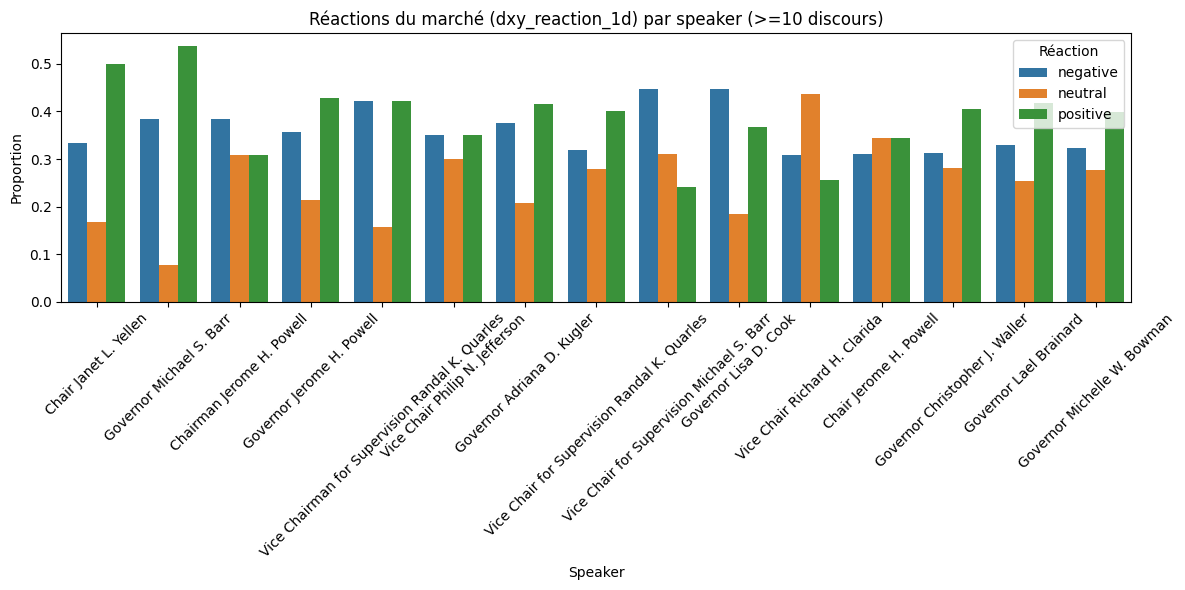

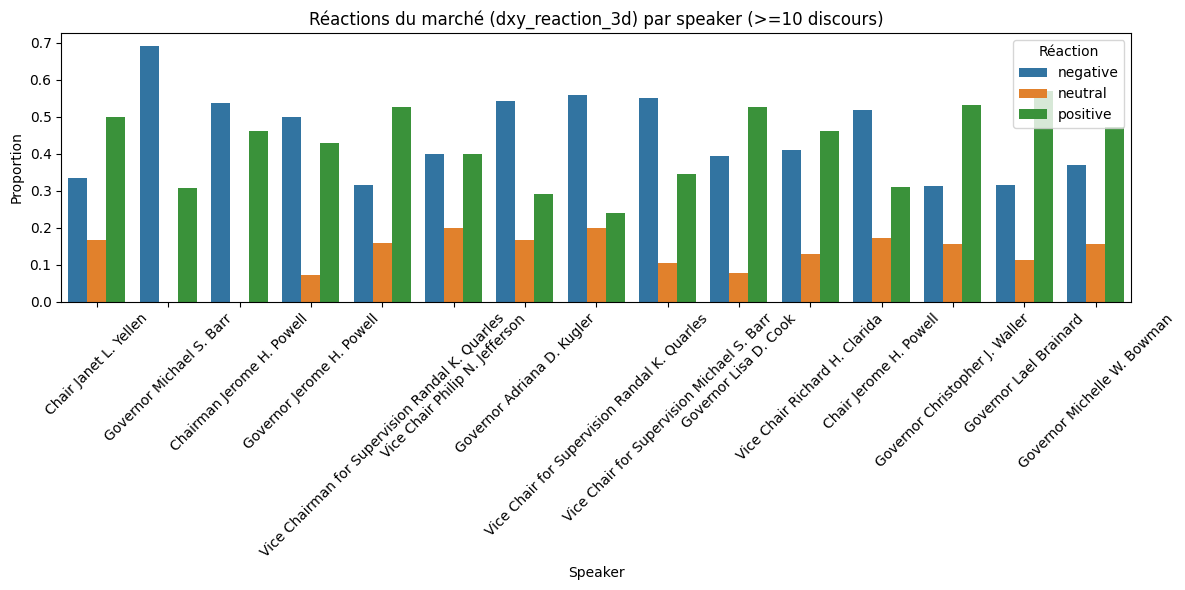

In [21]:
# Seuil minimal, trop de vol si qqun a fait très peu de discours
min_discours = 10

# Filtrer speakers avec + que 10 discours
speaker_counts = df_merged['speaker'].value_counts()
speakers_to_keep = speaker_counts[speaker_counts >= min_discours].index
df_filtered = df_merged[df_merged['speaker'].isin(speakers_to_keep)]

# On ordonne les speakers par ordre croissant de discours
speakers_ordered = speaker_counts[speakers_to_keep].sort_values().index

# Compter les réactions par speaker
reaction_cols = ['dxy_reaction_1d', 'dxy_reaction_3d']
for col in reaction_cols:
    summary = df_filtered.groupby(['speaker', col]).size().reset_index(name='count')
    summary_total = summary.groupby('speaker')['count'].transform('sum')
    summary['proportion'] = summary['count'] / summary_total

    plt.figure(figsize=(12,6))
    sns.barplot(
        data=summary,
        x='speaker',
        y='proportion',
        hue=col,
        order=speakers_ordered 
    )
    plt.title(f"Réactions du marché ({col}) par speaker (>=10 discours)")
    plt.xticks(rotation=45)
    plt.ylabel("Proportion")
    plt.xlabel("Speaker")
    plt.legend(title="Réaction")
    plt.tight_layout()
    plt.show()